# Portfolio Optimization - Finance Theory

## Code - Main calss

In [1]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import random
from typing import Union, Dict, List, Tuple
import logging
import plotly.io as pio

pio.renderers.default = "svg"
logging.basicConfig(filename='portfolio.log', level=logging.ERROR)


class Portfolio:
    """
    A class for portfolio optimization and analysis.

    Args:
      data (pd.DataFrame): DataFrame with historical asset prices.
      return_calc (str): Accepts either 'log' or 'simple' as the method to compute returns (default is log).
      intervals (int, optional): Number of trading intervals per year (default is 252).
      risk_free_rate (float, optional): Risk-free rate used for calculations (default is 0).
      minimum_weight (float, optional): Minimum weight for assets in the portfolio (default is 0).
      mult (float): multiplier of max sharp return to limit the frontier (default is 1.2).

    Attributes:
      data (pd.DataFrame): Historical asset price data.
      mean_returns (pd.Series): Mean returns for each asset.
      cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
      num_assets (int): Number of assets in the portfolio.
      intervals (int): Number of trading intervals per year.
      risk_free_rate (float): Risk-free rate used for calculations.
      minimum_weight (float): Minimum weight for assets in the portfolio.
    """

    def __init__(self, data, intervals=252, risk_free_rate=0, minimum_weight=0, return_calc='log', mult=1.2):
        self.return_calc = return_calc
        self.data = data
        self.mean_returns, self.cov_matrix = self.initial_process()
        self.num_assets = len(self.mean_returns)
        self.intervals = intervals
        self.risk_free_rate = risk_free_rate
        self.minimum_weight = minimum_weight
        self.mult = mult
        
    def initial_process(self) -> Tuple[pd.Series, pd.DataFrame]:
        """
        Perform initial data processing to calculate mean returns and the covariance matrix.

        Returns:
            Tuple[pd.Series, pd.DataFrame]: Mean returns and covariance matrix.
        """
        try:
            if not isinstance(self.data, pd.DataFrame) or self.data.empty:
                raise ValueError("Input data must be a non-empty DataFrame.")

            if self.return_calc == 'simple':
                returns = self.data.pct_change()
            elif self.return_calc == 'log':
                returns = np.log(self.data / self.data.shift(1))

            return returns.mean(), returns.cov()

        except Exception as e:
            logging.error(f"Error during initialization: {str(e)}")


    def portfolio_return(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the portfolio return.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Portfolio return.
        """
        try:
            if not isinstance(weights, (list, np.ndarray)) or len(weights) != self.num_assets:
                raise ValueError("Portfolio weights must be a list or numpy array of the same length as the number of assets.")
            return np.sum(self.mean_returns * weights) * self.intervals # transform into annually return

        except Exception as e:
            logging.error(f"Error in portfolio_return: {str(e)}")


    def portfolio_std(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the portfolio standard deviation.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Portfolio standard deviation.
        """
        try:
            if not isinstance(weights, (list, np.ndarray)) or len(weights) != self.num_assets:
                raise ValueError("Portfolio weights must be a list or numpy array of the same length as the number of assets.")
            return np.sqrt( np.dot(weights.T, np.dot(self.cov_matrix, weights)) ) * np.sqrt(self.intervals) #transform into annually variance

        except Exception as e:
            logging.error(f"Error in portfolio_std: {str(e)}")

    def get_neg_sharp_ratio(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the negative Sharpe ratio of the portfolio.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Negative Sharpe ratio.
        """
        p_returns = self.portfolio_return(weights)
        p_std = self.portfolio_std(weights)
        return - (p_returns - self.risk_free_rate) / p_std

    def max_sharp_ratio_portfolio(self) -> minimize:
        """
        Find the portfolio with the maximum Sharpe ratio.

        Returns:
            minimize: Result of the optimization.
        """
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (self.minimum_weight, 1)
        bounds = tuple(bound for asset in range(self.num_assets))
        result = minimize(self.get_neg_sharp_ratio,
                          self.num_assets*[1./self.num_assets],
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)#,options={'ftol': 1e-4, 'eps': 1e-4})

        if not result['success']:
            logging.error(f"Error in max_sharp_ratio_portfolio: {result['message']}")

        return result


    def min_var_portfolio(self, target_return: float = None) -> minimize:
        """
        Find the minimum variance portfolio.

        Args:
            target_return (float, optional): Target portfolio return for a specific portfolio (default is None).

        Returns:
            minimize: Result of the optimization.
        """

        if target_return:
            constraints = (
                           {'type':'eq','fun': lambda x: self.portfolio_return(x) - target_return},
                           {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                          )
        else:
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})


        bound = (self.minimum_weight, 1)
        bounds = tuple(bound for asset in range(self.num_assets))
        result = minimize(self.portfolio_std,
                          self.num_assets*[1./self.num_assets],
                          method='SLSQP',
                          bounds=bounds,
                          options={'maxiter':500},
                          constraints=constraints)

        if not result['success']:
            logging.error(f"Error in min_var_portfolio: {result['message']}")

        return result

    def get_efficient_frontier(self) -> Tuple[float, float, pd.DataFrame, float, float, pd.DataFrame, List[float], List[float]]:
        """
        Calculate the efficient frontier and key portfolios.

        Returns:
            Tuple[float, float, pd.DataFrame, float, float, pd.DataFrame, List[float], List[float]:
                - Maximum Sharpe ratio portfolio return, standard deviation, and allocation.
                - Minimum volatility portfolio return, standard deviation, and allocation.
                - List of portfolio standard deviations for the efficient frontier.
                - List of target returns for the efficient frontier.
        """

        # Max Sharpe Ratio Portfolio
        max_sharp_portfolio = self.max_sharp_ratio_portfolio()
        max_sharp_returns = self.portfolio_return(max_sharp_portfolio['x'])
        max_sharp_std = self.portfolio_std(max_sharp_portfolio['x'])
        max_sharp_allocation = pd.DataFrame(max_sharp_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])

        # Min Volatility Portfolio
        min_vol_portfolio = self.min_var_portfolio()
        min_vol_returns = self.portfolio_return(min_vol_portfolio['x'])
        min_vol_std = self.portfolio_std(min_vol_portfolio['x'])
        min_vol_allocation = pd.DataFrame(min_vol_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])

        # Efficient Frontier
        efficient_frontier_list = []

        target_return_list = np.linspace(min_vol_returns, max_sharp_returns*self.mult, 50)
        for target in target_return_list:
            efficient_frontier_list.append(self.min_var_portfolio(target_return=target)['fun'])

        return max_sharp_returns, max_sharp_std, max_sharp_allocation, min_vol_returns, min_vol_std, min_vol_allocation, efficient_frontier_list, target_return_list


    def simulate_portfolios(self, max_r: float, max_std: float, trials: int = 5000) -> Tuple[List[float], List[float], List[List[float]]]:
        """
        Simulate random portfolios with specified constraints.

        Args:
            max_r (float): Maximum allowed return.
            max_std (float): Maximum allowed standard deviation.
            trials (int, optional): Number of portfolio simulations (default is 5000).

        Returns:
            Tuple[List[float], List[float], List[List[float]]:
                - List of portfolio returns.
                - List of portfolio standard deviations.
                - List of portfolio weightings.
        """

        returns, stds, results = [], [], []
        for _ in tqdm(range(trials)):
            # Generate random weights
            weights = np.random.exponential(scale=0.5, size=self.num_assets)
            
            # Randomly select indices to change to minimum weigh
            indices_to_change = random.sample(range(len(weights)), np.random.randint(1, int(len(weights)*0.8)))
            
            # Create a new list with elements changed to minimum weight
            weights = [self.minimum_weight if i in indices_to_change else elem for i, elem in enumerate(weights)]
            
            # Normalize to ensure the weights sum to 1
            weights /= np.sum(weights)
            
            # Get retrun and std
            p_return = self.portfolio_return(weights)
            p_std = self.portfolio_std(weights)
            
            # Make limits of maximum retruns and std
            if p_return > max_r or p_std > max_std:
                pass
            else:
                returns.append(p_return)
                stds.append(p_std)
                results.append(weights)
        return returns, stds, results


    def create_cml(self, max_sharp_return: float, max_sharp_std: float, max_leverage=2.0):
        """
        Create a Capital Market Line (CML) by combining the given maximum Sharpe ratio return and standard deviation.

        Args:
            max_sharp_return (float): The maximum Sharpe ratio return.
            max_sharp_std (float): The standard deviation corresponding to the maximum Sharpe ratio.
            max_leverage (float): The maximum leverage that allowed (default is 200% )
        """
        self.cml = {'returns':[], 'stds':[], 'leverage_returns':[], 'leverage_stds':[]}

        for i in np.linspace(0, max_leverage, 60):
            Wp = i
            Wrf = 1-Wp
            if i <= 1:
                self.cml['returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
                self.cml['stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
            else:
                self.cml['leverage_returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
                self.cml['leverage_stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0


    # Could be outside from the class
    def plot_efficient_frontier(self, with_cml=False) -> go.Figure:
        """
        Plot the efficient frontier and portfolio optimization results.

        Returns:
            go.Figure: Plotly figure displaying the efficient frontier.
        """
        # Get the Efficient Frontier data
        max_sharp_returns, max_sharp_std, _, min_vol_returns, min_vol_std, _, efficient_frontier_list, target_return_list = self.get_efficient_frontier()

        # Get the CML (Capital Market Line) data
        self.create_cml(max_sharp_returns, max_sharp_std)

        # Get the random combination portfolios
        returns, stds, _ = self.simulate_portfolios(max_r=max_sharp_returns*1.5, max_std=max_sharp_std*1.5)

        # Efficient Frontier portfolios
        EfficientFrontier = go.Scatter(
            name='Efficient Frontier',
            mode='lines',
            opacity=0.7,
            x=[ef_std for ef_std in efficient_frontier_list],
            y=[target for target in target_return_list],
            line=dict(color='black', width=3, dash='dash')
        )

        # Max Sharp Ratio portfolio
        MaxSharpeRatio = go.Scatter(
            name='Maximium Sharpe Ratio',
            mode='markers',
            x=[max_sharp_std],
            y=[max_sharp_returns],
            marker=dict(color='red',size=14,line=dict(width=1, color='black'))
        )
        # Min volatility portfolio
        MinVol = go.Scatter(
            name='Mininium Volatility',
            mode='markers',
            x=[min_vol_std],
            y=[min_vol_returns],
            marker=dict(color='green',size=14,line=dict(width=1, color='black'))
        )

        # Random Portfolios
        RandomPortfolios = go.Scatter(
            name='Random Weights Portfolios',
            mode='markers',
            opacity=0.5,
            x=stds,
            y=returns,
            line=dict(color='blue', width=0.5)
        )
        # CML (Capital Market Line)
        CML = go.Scatter(
            name='CML (Capital Market Line)',
            mode='lines',
            opacity=0.8,
            x=[cml_std for cml_std in self.cml['stds']],
            y=[cml_return for cml_return in self.cml['returns']],
            line=dict(color='blue', width=2.5)
        )

        # Leveraged CML (Capital Market Line)
        LeveragedCML = go.Scatter(
            name='Leveraged CML (Capital Market Line)',
            mode='lines',
            opacity=0.6,
            x=[cml_std for cml_std in self.cml['leverage_stds']],
            y=[target for target in self.cml['leverage_returns']],
            line=dict(color='blue', width=2.5, dash='dash')
        )
        if with_cml:
            data = [MaxSharpeRatio, MinVol, EfficientFrontier, RandomPortfolios, CML, LeveragedCML]
            title = 'Portfolio Optimization with the Efficient Frontier and CML'

        else:
            data = [MaxSharpeRatio, MinVol, EfficientFrontier, RandomPortfolios]
            title = 'Portfolio Optimization with the Efficient Frontier'


        layout = go.Layout(
            title = title,
            yaxis = dict(title='Annualised Return (%)'),
            xaxis = dict(title='Annualised Volatility (%)'),
            showlegend = True,
            legend = dict(x = 0.75, y = 0, traceorder='normal',
                          bgcolor='#E2E2E2',
                          bordercolor='black',
                          borderwidth=2),
            width=800,
            height=600)

        fig = go.Figure(data=data, layout=layout)
        return fig.show()


## Get The Stock Data

Begin by retrieving daily stock data from Yahoo Finance library for the period
from '2015-01-01' to '2023-10-01'. \
I'm specifically interested in the 'Close' data, which will be saved as a Pandas DataFrame.


In [2]:
# Define a list of stock symbols
stock_symbols = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "JNJ", "BRK-B", "JPM",
                 "WMT", "DIS", "PG","V", "PYPL", "NFLX", "CRM", "CSCO", "INTC", "T",
                 "BA", "MA", "XOM", "PEP", "ADBE", "CMCSA", "KO", "HD", "UNH", "TMUS"]
# Define the date range for historical data
start_date = "2015-01-01"
end_date = "2023-10-01"

def get_data(stock_symbols: list, start: str, end: str, period="1d"):
    stock_data = {}

    for symbol in stock_symbols:
        stock = yf.Ticker(symbol)
        stock_history = stock.history(period=period, start=start_date, end=end_date)
        stock_data[symbol] = stock_history

    return pd.DataFrame({symbol: data["Close"] for symbol, data in stock_data.items()})


df = get_data(stock_symbols, start_date, end_date)
df.head().iloc[:, :5]

,AAPL,MSFT,GOOGL,TSLA,AMZN
Date,,,,,
2015-01-02 00:00:00-05:00,24.498684,40.534832,26.477501,14.620667,15.4260
2015-01-05 00:00:00-05:00,23.808512,40.162094,25.973000,14.006000,15.1095
2015-01-06 00:00:00-05:00,23.810762,39.572624,25.332001,14.085333,14.7645
2015-01-07 00:00:00-05:00,24.144634,40.075397,25.257500,14.063333,14.9210
2015-01-08 00:00:00-05:00,25.072330,41.254353,25.345501,14.041333,15.0230


Next, initializing an object and then, the initial step involves preprocessing, where the DataFrame is utilized to compute returns for all assets.
```
returns = self.data.pct_change()
returns.mean(), returns.cov()
```



## Create Portfolio Object And Examine The Methods
Let's take a look how the main datasets looks like.

In [3]:
portfolio = Portfolio(df)

print(f"Mean Returns: \n\n{portfolio.mean_returns.head()} \n\nCovariance Matrix: \n")
portfolio.cov_matrix.head().iloc[:, :5]

Mean Returns: 

AAPL     0.000884
MSFT     0.000933
GOOGL    0.000726
TSLA     0.001291
AMZN     0.000959
dtype: float64 

Covariance Matrix: 



,AAPL,MSFT,GOOGL,TSLA,AMZN
AAPL,0.000342,0.000228,0.000209,0.000288,0.000222
MSFT,0.000228,0.000311,0.000234,0.000266,0.000244
GOOGL,0.000209,0.000234,0.000321,0.000247,0.000247
TSLA,0.000288,0.000266,0.000247,0.001274,0.000302
AMZN,0.000222,0.000244,0.000247,0.000302,0.000439


The 'portfolio_return' method calculates and returns the portfolio's performance, based on `mean_returns` and specific weightings.

```
np.sum(self.mean_returns * weights) * self.intervals
```

The 'portfolio_std' method computes and returns the portfolio's risk in terms of standard deviation, using `cov_matrix` and specific weightings.


```
np.sqrt( np.dot(weights.T, np.dot(self.cov_matrix, weights)) ) * np.sqrt(self.intervals)
```

Both methods convert the values into annual terms, assuming 252 trading days in a year.\
Other methods will make use of these two methods.

In [4]:
# Create random weights
random_weights = np.array([random.uniform(0, 1) for _ in range(len(portfolio.mean_returns))])
# Normalize to 1
random_weights /= random_weights.sum()

print(f"Random portfolio return: {portfolio.portfolio_return(random_weights)} \nRandom portfolio std: {portfolio.portfolio_std(random_weights)}")

Random portfolio return: 0.12882786956322823 
Random portfolio std: 0.19203999751860729


The 'max_sharp_ratio_portfolio' method calculates the portfolio's Sharpe ratio using the mean return and covariance matrix.\
Since we are minimizing, it results in negative values.

```
p_returns = self.portfolio_return(weights)
p_std = self.portfolio_std(weights)
return - (p_returns - self.risk_free_rate) / p_std
```

The Sharpe Ratio, is a measure of the risk-adjusted return of an investment or portfolio.\
It helps investors assess the return they receive for the level of risk taken. \
The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} (S) = \frac{R_p - R_f}{\sigma_p}
$$
Where:
- **S** is the Sharpe Ratio.
- **Rp** is the portfolio's expected return.
- **Rf** is the risk-free rate of return.
- **σp** is the standard deviation (volatility) of the portfolio's returns.

In [5]:
print("Max Sharp Ratio Weights:\n\n", portfolio.max_sharp_ratio_portfolio()['x'],'\n\n\n')
portfolio.max_sharp_ratio_portfolio()

Max Sharp Ratio Weights:

 [8.15365867e-02 1.73510884e-01 0.00000000e+00 6.90784145e-02
 1.40629238e-01 0.00000000e+00 0.00000000e+00 3.68222163e-17
 2.80169077e-02 1.34712120e-16 2.13045727e-17 0.00000000e+00
 3.30383507e-16 1.99628725e-16 3.99664026e-17 8.79152437e-17
 0.00000000e+00 0.00000000e+00 4.05559375e-16 0.00000000e+00
 1.10710594e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33085817e-17 3.11188571e-01 1.96039399e-01] 





 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0103403094349679
       x: [ 8.154e-02  1.735e-01 ...  3.112e-01  1.960e-01]
     nit: 8
     jac: [ 1.910e-04 -3.564e-04 ...  1.263e-04  4.810e-05]
    nfev: 232
    njev: 8

## Minimum Volatility Portfolio
The Minimum Volatility Portfolio theory is an investment approach that aims to construct a portfolio with the lowest possible level of risk (volatility) while achieving a target level of return. This theory is often used in the context of Modern Portfolio Theory (MPT) and relies on diversification to reduce risk. Here's an explanation along with relevant formulas:

**Theory:**

The key idea behind the Minimum Volatility Portfolio is to select a combination of assets in such a way that the portfolio's overall risk, as measured by standard deviation or volatility, is minimized, while still achieving a desired level of return. This portfolio is typically positioned on the efficient frontier of MPT.

**Formulas:**
**Portfolio Expected Return (Rp):**

The expected return of the portfolio is calculated as a weighted average of the individual asset returns in the portfolio:\
$$R_p = \sum_{i=1}^{n} w_i \cdot R_i$$

Where:

- `Rp`: is the portfolio's expected return.
- `wi`: is the weight of the i-th asset in the portfolio.
- `Ri`: is the expected return of the i-th asset.

**Portfolio Standard Deviation (σp):**

The portfolio's standard deviation (volatility) is calculated as follows:

$$
\sigma_p = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_i \cdot \sigma_j \cdot \rho_{ij}}
$$
Where:

 - `σp`: is the standard deviation of the portfolio.
 - `wi` and `wj`: are the weights of the i-th and j-th assets.
 - `σi` and `σj`: are the standard deviations of the i-th and j-th assets.
 - `ρij`: is the correlation between the i-th and j-th assets.


**Optimization:**

To find the Minimum Volatility Portfolio, an optimization process is used to find the set of asset weights (`wi`) that minimizes the portfolio standard deviation (`σp`) while maintaining a target level of return (`Rp`).

\begin{align*}
\text{Minimize:} \quad & \sigma_p = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_i \cdot \sigma_j \cdot \rho_{ij}} \\
\text{Subject to:} \\\quad & \sum_{i=1}^{n} w_i = 1 \\
& R_p \geq R_{\text{target}}
\end{align*}



**The Method min_var_portfolio:** \
If the 'target_return' is not specified, \
constraint requires that the sum of all weights equals 1.
```
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
```
When the 'target_return' is provided, the constraints involve two conditions: all weights must still sum to 1, and the portfolio's return must equal the specified 'target_return.' \
Given that value, the optimization aims to minimize the portfolio's variance.

```
if target_return:
  constraints = (
                {'type':'eq','fun': lambda x: self.portfolio_return(x) - target_return},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                )
```

Another set of constraints involves bounding each weight within the range of 'minimum_weight' to 1, effectively disallowing short positions on assets. These bounds are applied to the weights of each individual asset.

```
bound = (self.minimum_weight, 1)
bounds = tuple(bound for asset in range(self.num_assets))
```

Utilize the SLSQP method to identify the weightings that minimize portfolio variance, while adhering to the specified constraints and bounds. The initial weights, as shown in `self.num_assets*[1./self.num_assets]`, provide an equal allocation to each asset.

Sequential Least Squares Quadratic Programming (SLSQP) method to find the optimal asset weights that minimize portfolio variance. It begins with an equal distribution of weights to each asset and iteratively adjusts them based on the constraints and bounds to reach the minimum variance portfolio.

```
result = minimize(self.portfolio_std,
                  self.num_assets*[1./self.num_assets],
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)
```

In [6]:
print("Min Var Portfolio Weights:\n\n", portfolio.min_var_portfolio()['x'],'\n\n\n')
portfolio.min_var_portfolio()

Min Var Portfolio Weights:

 [0.00000000e+00 0.00000000e+00 4.83984538e-18 5.31294803e-18
 3.61176579e-02 2.49260486e-01 1.98049125e-02 5.11464120e-18
 1.79997836e-01 7.98824861e-18 1.26088615e-01 0.00000000e+00
 0.00000000e+00 9.30734685e-03 3.52952808e-18 1.89329947e-18
 0.00000000e+00 8.01768502e-02 1.45263907e-17 1.17254639e-17
 3.90407755e-02 0.00000000e+00 1.01843337e-17 3.95767663e-03
 2.06796963e-01 0.00000000e+00 8.90500279e-19 4.94508793e-02] 





 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1464710847131619
       x: [ 0.000e+00  0.000e+00 ...  8.905e-19  4.945e-02]
     nit: 13
     jac: [ 1.623e-01  1.684e-01 ...  1.530e-01  1.465e-01]
    nfev: 377
    njev: 13

## The Efficient Frontier
The Efficient Frontier is a fundamental concept in modern portfolio theory (MPT), which was developed by Harry Markowitz. It represents a set of optimal portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of expected return. In other words, the Efficient Frontier outlines the trade-off between risk and return for a diversified portfolio of assets.


In summary, \
Efficient Frontier is a visual representation of the risk-return relationship for diversified portfolios and serves as a valuable tool for investors in designing their investment strategies. It helps investors make informed decisions about how to allocate their assets to achieve their financial objectives while considering their risk tolerance.

----------------------------------------------------


Here, we obtain the portfolio with the highest Sharpe ratio and its properties.
```
# Max Sharpe Ratio Portfolio
max_sharp_portfolio = self.max_sharp_ratio_portfolio()
max_sharp_returns = self.portfolio_return(max_sharp_portfolio['x'])
max_sharp_std = self.portfolio_std(max_sharp_portfolio['x'])
max_sharp_allocation = pd.DataFrame(max_sharp_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])
```
Here, we secure the portfolio with the least amount of volatility and explore its attributes.
```
# Min Volatility Portfolio
min_vol_portfolio = self.min_var_portfolio()
min_vol_returns = self.portfolio_return(min_vol_portfolio['x'])
min_vol_std = self.portfolio_std(min_vol_portfolio['x'])
min_vol_allocation = pd.DataFrame(min_vol_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])
```
To discover the Efficient Frontier, we determine portfolio weights that minimize variance while targeting specific returns, ranging from the minimum volatility returns to the maximum Sharpe ratio returns, with an additional X%.
```
# Efficient Frontier
efficient_frontier_list = []
target_return_list = np.linspace(min_vol_returns, max_sharp_returns*1.3, 50)
for target in target_return_list:
    efficient_frontier_list.append(self.min_var_portfolio(target_return=target)['fun'])
```

,Efficient Frontier return,Efficient Frontier std
0,0.085021,0.146471
1,0.088596,0.146548
2,0.092172,0.146764
3,0.095747,0.147093
4,0.099322,0.147524


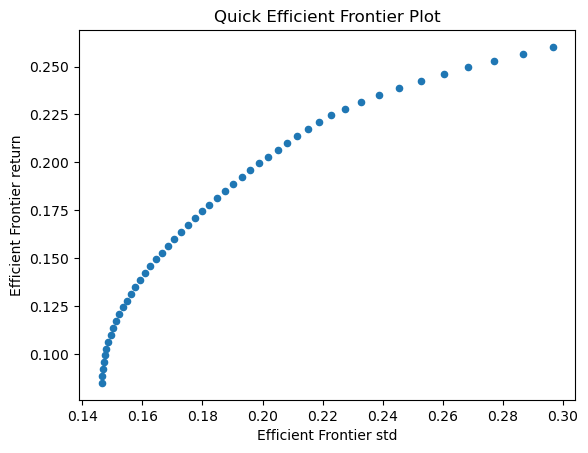

In [7]:
results = portfolio.get_efficient_frontier()
ef_df = pd.DataFrame({"Efficient Frontier return": results[-1], "Efficient Frontier std": results[-2]})
ef_df.plot(kind='scatter', x="Efficient Frontier std", y="Efficient Frontier return", title="Quick Efficient Frontier Plot")
ef_df.head()


To facilitate the comparison and visualization of efficient portfolios, I generated portfolios with random weight combinations.\
I opted for an exponential distribution to allow for the possibility of assigning higher weights to certain assets.\
Furthermore, I intentionally assigned a value of 0 (or the minimum value) to approximately 20% of the assets.

```
returns, stds, results = [], [], []
for _ in tqdm(range(trials)): # trials = 5000
  # Generate random weights
  weights = np.random.exponential(scale=0.5, size=self.num_assets)

  # Randomly select indices to change to minimum weigh
  indices_to_change = random.sample(range(len(weights)), np.random.randint(1, int(len(weights)*0.8)))

  # Create a new list with elements changed to minimum weight
  weights = [self.minimum_weight if i in indices_to_change else elem for i, elem in enumerate(weights)]

  # Normalize to ensure the weights sum to 1
  weights /= np.sum(weights)
```



100%|██████████| 5000/5000 [00:01<00:00, 2511.48it/s]


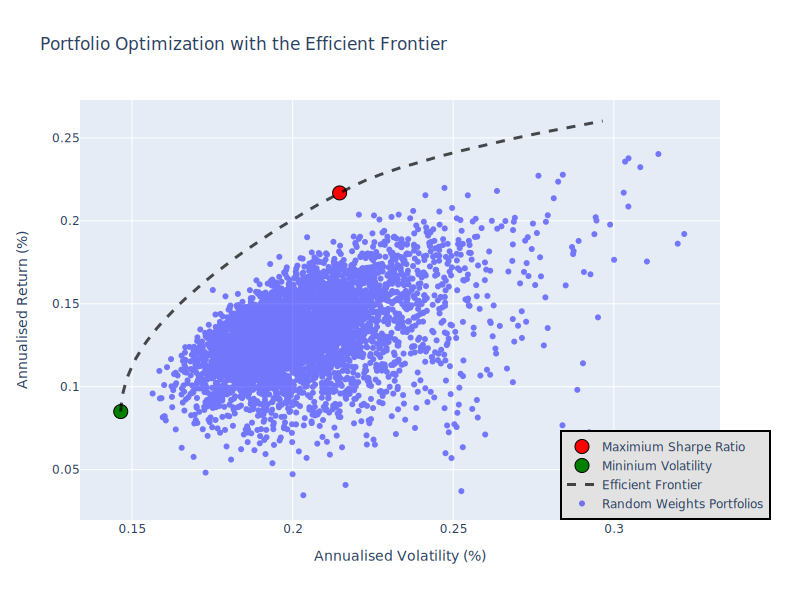

In [8]:
portfolio.plot_efficient_frontier()

Let's observe how the weights we assign to each asset are distributed.

In [9]:
pd.DataFrame([portfolio.max_sharp_ratio_portfolio()['x'], stock_symbols]).T

,0,1
0,0.081537,AAPL
1,0.173511,MSFT
2,0.0,GOOGL
3,0.069078,TSLA
4,0.140629,AMZN
5,0.0,JNJ
6,0.0,BRK-B
7,0.0,JPM
8,0.028017,WMT
9,0.0,DIS


## Explore Results With Different Parameters
Let's experiment with the parameters a bit and observe the effects of altering the risk-free rate and minimum weights.

100%|██████████| 5000/5000 [00:02<00:00, 2251.19it/s]


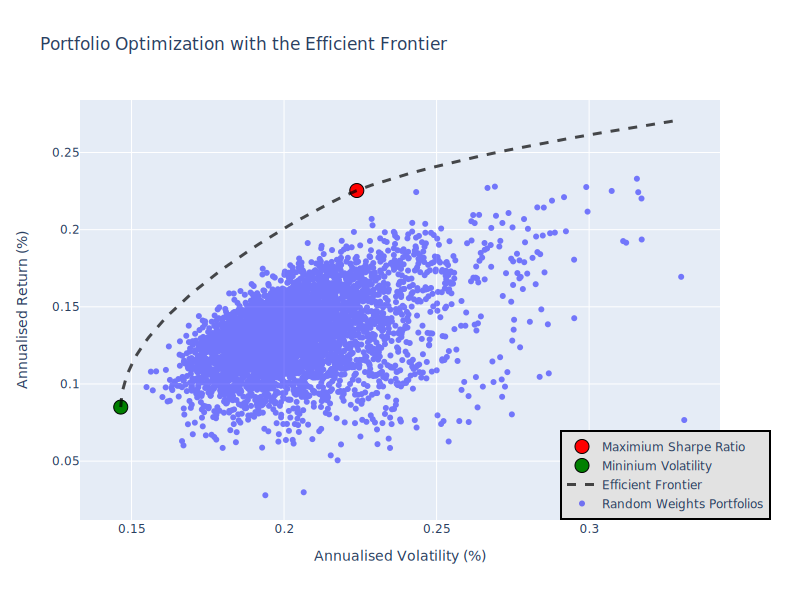

Max Sharp Ratio Return: 0.2253526751850599


In [10]:
portfolio.risk_free_rate = 0.05
portfolio.plot_efficient_frontier()
print(f"Max Sharp Ratio Return: {portfolio.portfolio_return(portfolio.max_sharp_ratio_portfolio()['x'])}")


C:\Users\TomerA\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|██████████| 5000/5000 [00:02<00:00, 2407.52it/s]


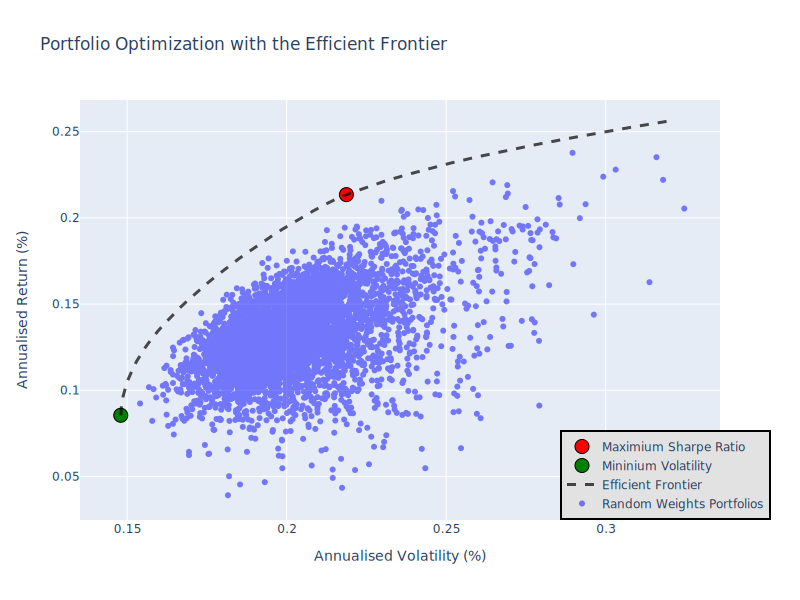



Max Sharp Ratio Return: 0.213473534140231




,0,1
0,0.047989,AAPL
1,0.184211,MSFT
2,0.005,GOOGL
3,0.097619,TSLA
4,0.146389,AMZN
5,0.005,JNJ
6,0.005,BRK-B
7,0.005,JPM
8,0.005,WMT
9,0.005,DIS


In [11]:
portfolio.risk_free_rate = 0.05
portfolio.minimum_weight = 0.005
portfolio.plot_efficient_frontier()
print(f"\n\nMax Sharp Ratio Return: {portfolio.portfolio_return(portfolio.max_sharp_ratio_portfolio()['x'])}\n\n")
pd.DataFrame([portfolio.max_sharp_ratio_portfolio()['x'], stock_symbols]).T

## Capital Market Line (CML)
The Capital Market Line (CML) is a fundamental concept in finance that showcases the optimal blend of risk and return in investment portfolios. It is a theoretical framework encompassing all portfolios that strike an optimal balance between the risk-free rate of return and the market portfolio, comprised of risky assets. According to the Capital Asset Pricing Model (CAPM), in a state of equilibrium, all investors are inclined to position themselves along the CML by either borrowing or lending at the risk-free rate. This strategic positioning allows investors to maximize their return for a given level of risk, ensuring an efficient risk-return trade-off.

<br>

**The Capital Market Line (CML) equation:**
\begin{align}
R_i &= R_f + \frac{E[R_m] - R_f}{\sigma_m} \cdot \sigma_i
\end{align}

Where:
- $R_i$ = Expected return of a portfolio or asset $i$ 
- $R_f$ = Risk-free rate of return 
- $E[R_m]$ = Expected return of the market portfolio 
- $\sigma_m$ = Standard deviation of the market portfolio 
- $\sigma_i$ = Standard deviation of portfolio or asset $i$

<br>

**The Capital Asset Pricing Model (CAPM) equation:**
\begin{align}
E[R_i] &= R_f + \beta_i \cdot (E[R_m] - R_f)
\end{align}

Where:
- $E[R_i]$ = Expected return of portfolio or asset $i$ 
- $R_f$ = Risk-free rate of return 
- $\beta_i$ = Beta of portfolio or asset $i$ 
- $E[R_m]$ = Expected return of the market portfolio


<br>

In the code, I create the line (CML) by adjusting the allocation of weights between the portfolio with the maximum Sharpe ratio and the risk-free asset, resulting in a new portfolio with its own return and standard deviation. It's worth noting that the risk-free asset has a standard deviation of 0.

Additionally, I enable the option to leverage the new portfolio, allowing for short positions on the risk-free asset (either borrowing or taking a loan) and potentially increasing the allocation to the portfolio with the maximum Sharpe ratio beyond 100%.

```
self.cml = {'returns':[], 'stds':[], 'leverage_returns':[], 'leverage_stds':[]}

for i in np.linspace(0, max_leverage, 60):
  Wp = i
  Wrf = 1-Wp
  if i <= 1:
    self.cml['returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
    self.cml['stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
  else:
    self.cml['leverage_returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
    self.cml['leverage_stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
```

C:\Users\TomerA\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|██████████| 5000/5000 [00:01<00:00, 2518.41it/s]


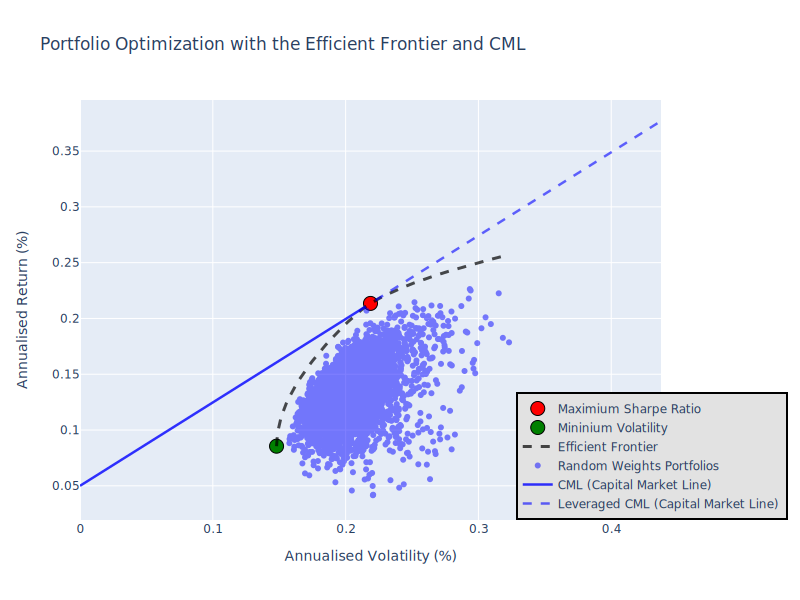

In [12]:
portfolio.risk_free_rate = 0.05
portfolio.minimum_weight = 0.005
portfolio.plot_efficient_frontier(with_cml=True)